In [1]:
import pandas as pd 
user_data = pd.read_csv('aiffel/customer_segmentation/user_data.csv')

In [2]:
user_data.head()

,CustomerID,purchase_cnt,item_cnt,recency,user_total,user_average,unique_products,average_interval,total_transactions,cancel_frequency,cancel_rate
0,16148,1,72,296,76.3,76.3,1,0.0,1,0,0.0
1,17995,1,133,281,76.1,76.1,2,0.0,1,0,0.0
2,13130,1,32,94,64.0,64.0,2,0.0,1,0,0.0
3,12855,1,30,372,38.1,38.1,3,0.0,1,0,0.0
4,12789,1,3,65,76.9,76.9,3,0.0,1,0,0.0


# RFM Score

## Recency

In [ ]:
CREATE OR REPLACE TABLE aiffel-411000.modulabs_project.user_r AS

SELECT
  CustomerID, 
    -- 과거 데이터 사용으로 마지막 날짜 - InvoiceDay 활용
  EXTRACT(DAY FROM MAX(InvoiceDay) OVER () - InvoiceDay) AS recency
FROM (
  SELECT 
    CustomerID,
    MAX(DATE(InvoiceDate)) AS InvoiceDay
  FROM aiffel-411000.modulabs_project.data
  GROUP BY CustomerID
);

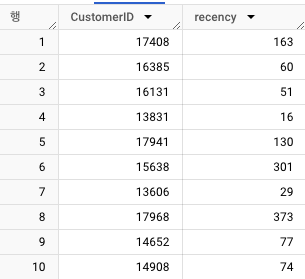

## Frequency

In [ ]:
CREATE OR REPLACE TABLE aiffel-411000.modulabs_project.user_rf AS

-- (1) 전체 거래 건수 계산
WITH purchase_cnt AS ( 
  SELECT
  CustomerID,
  count(InvoiceNo) AS purchase_cnt
  FROM aiffel-411000.modulabs_project.data
group by CustomerID
),

-- (2) 구매한 아이템 총 수량 계산
item_cnt AS (
  SELECT
  CustomerID,
  sum(Quantity) AS item_cnt
  FROM aiffel-411000.modulabs_project.data
group by CustomerID
)

-- 기존의 user_r에 (1)과 (2)를 통합
SELECT
  pc.CustomerID,
  pc.purchase_cnt,
  ic.item_cnt,
  ur.recency
FROM purchase_cnt AS pc
JOIN item_cnt AS ic
  ON pc.CustomerID = ic.CustomerID
JOIN aiffel-411000.modulabs_project.user_r AS ur
  ON pc.CustomerID = ur.CustomerID;

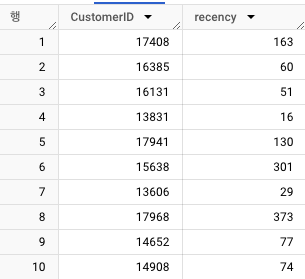

## Monetary

In [ ]:
CREATE OR REPLACE TABLE aiffel-411000.modulabs_project.user_rfm AS   
SELECT
  rf.CustomerID AS CustomerID,
  rf.purchase_cnt,
  rf.item_cnt,
  rf.recency,
  ut.user_total,
  ut.user_total / rf.purchase_cnt AS user_average
FROM aiffel-411000.modulabs_project.user_rf rf
LEFT JOIN (
  -- 고객 별 총 지출액
  SELECT
    CustomerID,
  round(sum(Quantity * UnitPrice),1) as user_total
from
  aiffel-411000.modulabs_project.data
group by
  CustomerID
) ut
ON rf.CustomerID = ut.CustomerID;

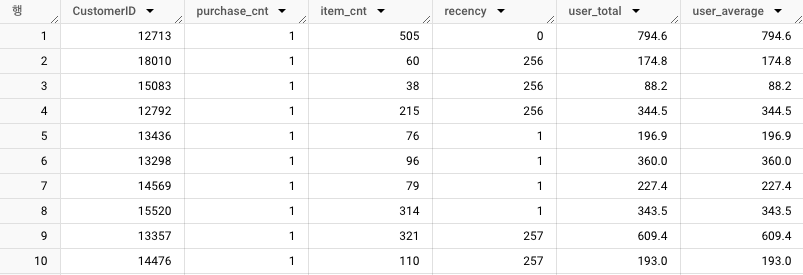

## RFM Score 추출

In [ ]:
WITH ranked_customers AS (
    SELECT
        CustomerID,
        recency,
        purchase_cnt,-- F에는 구매 건수로만 사용
        user_total,
        NTILE(5) OVER (ORDER BY recency) AS R,
        NTILE(5) OVER (ORDER BY purchase_cnt DESC) AS F,
        NTILE(5) OVER (ORDER BY user_total DESC) AS M
    FROM
        aiffel-411000.modulabs_project.user_rfm
)
SELECT *, (r + F + M) as RFMScore
FROM ranked_customers
ORDER BY CustomerID;

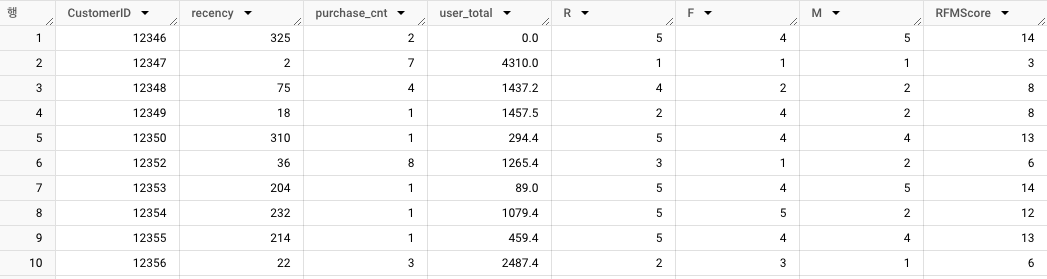

ORDER BY RFMScore desc로 변경하여 검색하여 555 인 케이스를 보는데 user_total이 -29.9임에도 5점이 발견되어

점수 정렬을 아래와 같이 변경 하였더니 가격 가격은 맞춰진 것으로 보이지만 recency가 10과 1이 모두 5점으로 측정되어 문제가 있는 것으로 보여짐
정확한 원인은 찾지 못했습니다..
        NTILE(5) OVER (ORDER BY recency desc) AS R,
        NTILE(5) OVER (ORDER BY purchase_cnt) AS F,
        NTILE(5) OVER (ORDER BY user_total) AS M

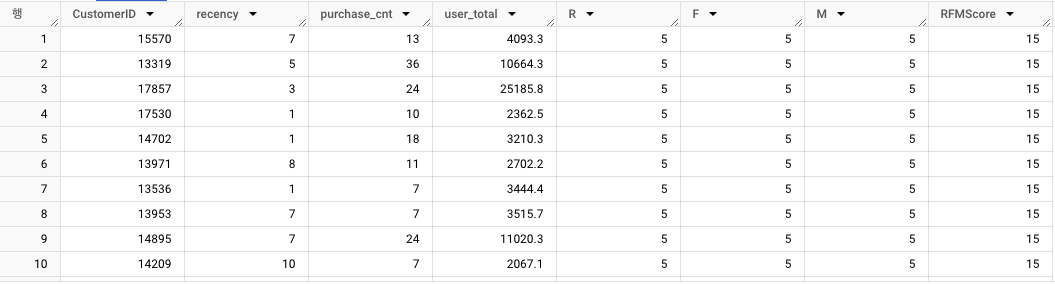

# Feature

## 구매하는 제품의 다양성

In [ ]:
WITH unique_products AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT StockCode) AS unique_products
  FROM aiffel-411000.modulabs_project.data
  GROUP BY CustomerID
)
SELECT ur.*, up.* EXCEPT (CustomerID)
FROM aiffel-411000.modulabs_project.user_rfm AS ur
JOIN unique_products AS up
ON ur.CustomerID = up.CustomerID;

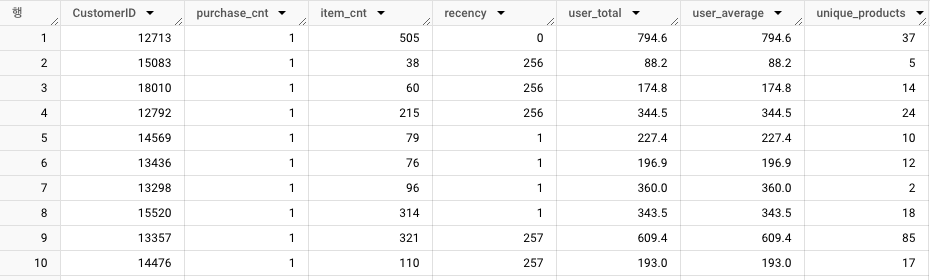

## 평균 구매 주기

In [ ]:
CREATE OR REPLACE TABLE project_name.modulabs_project.user_data AS 
WITH purchase_intervals AS (
  -- (2) 고객 별 구매와 구매 사이의 평균 소요 일수
  SELECT
    CustomerID,
    CASE WHEN ROUND(AVG(interval_), 2) IS NULL THEN 0 ELSE ROUND(AVG(interval_), 2) END AS average_interval
  FROM (
    -- (1) 구매와 구매 사이에 소요된 일수
    SELECT
      CustomerID,
      DATE_DIFF(InvoiceDate, LAG(InvoiceDate) OVER (PARTITION BY CustomerID ORDER BY InvoiceDate), DAY) AS interval_
    FROM
      aiffel-411000.modulabs_project.data
    WHERE CustomerID IS NOT NULL
  )
  GROUP BY CustomerID
)

SELECT u.*, pi.* EXCEPT (CustomerID)
FROM aiffel-411000.modulabs_project.user_data AS u
LEFT JOIN purchase_intervals AS pi
ON u.CustomerID = pi.CustomerID;

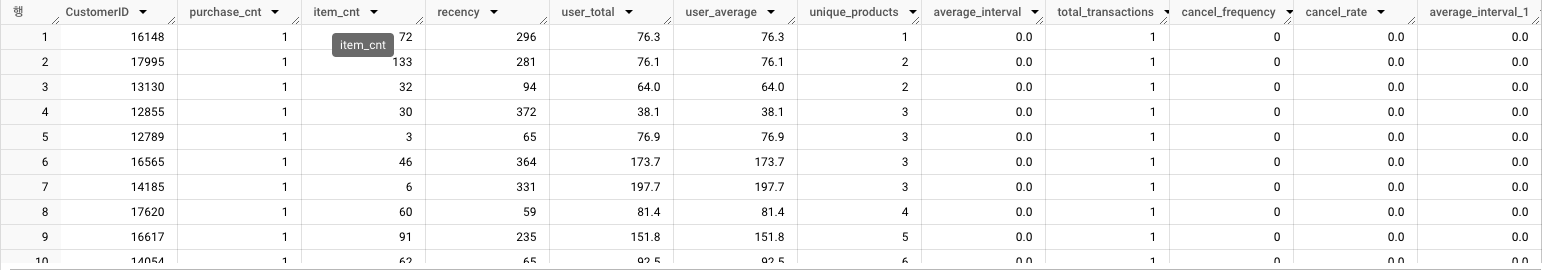

## 구매 취소 경향성

In [ ]:
CREATE OR REPLACE TABLE aiffel-411000.modulabs_project.user_data AS

WITH TransactionInfo AS (
  SELECT
    CustomerID,
    count(DISTINCT InvoiceNo) AS total_transactions,
    count(CASE WHEN InvoiceNo like 'C%' then InvoiceNo END) AS cancel_frequency
  FROM aiffel-411000.modulabs_project.data
  GROUP BY CustomerID
)

SELECT u.*, t.* EXCEPT(CustomerID), cancel_frequency / total_transactions * 100 AS cancel_rate
FROM `aiffel-411000.modulabs_project.user_data` AS u
LEFT JOIN TransactionInfo AS t
ON u.CustomerID = t.CustomerID

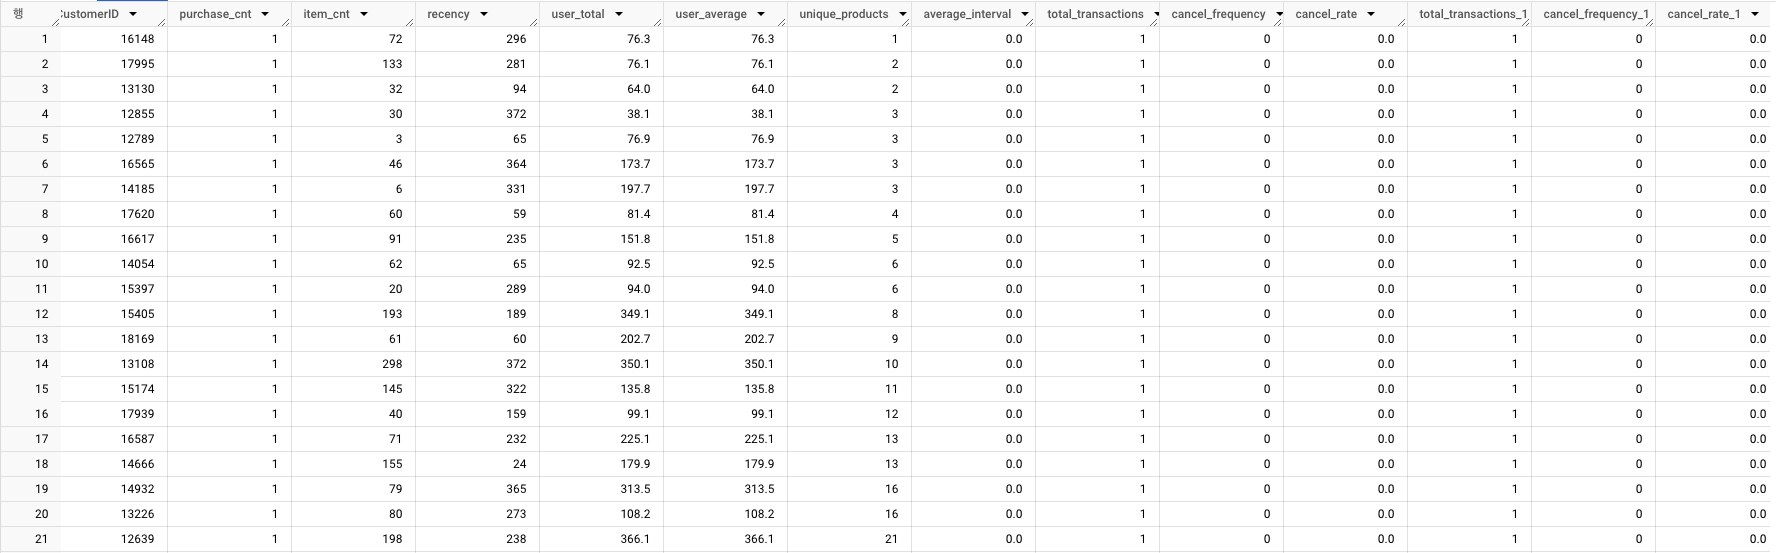

# 회고

RFM 분석 후반부 중 실수로 잘못된 데이터 값이 Replaced 되며 진행했던 과정을 처음부터 시작하게되며,
빠르게 진행하기 위해 노력하다보니 중간 잘못된 데이터 값으로 인해 결과 LMS에 표시된 값과 미세하게 차이가 발생했습니다.

과정 중 발생한 오류를 찾기위해 시간을 많이 빼았겼으나 시간이 부족하여 데이터를 분석하는 시간을 많이 갖지 못해 아쉬움이 남았습니다.

결과물을 만드는 것 보다는 과정에 집중하여 최대한 내용을 이해하기 위해 노력하였고 처음에는 낮설게 느껴졌던 SQL이 조금씩 활용할 수 있게되며 이전 직장에서 이러한 부분을 공부했었다면 더 좋은 인사이트를 만들 수 있었겠다는 생각이 들었습니다.

이번 과제 결과와는 별개로 지금까지 교육 중 가장 궁금한 부분이 많아 찾아보며 공부하는 것이 재미있었고 추가적으로 데이터를 분석하는 방법에 대해 얼른 배워보고 싶다고 느꼈습니다.